In [1]:
from policy import *
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [2]:
def get_dataloaders(train_dataset, test_dataset, batch_size):
    
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=len(test_dataset))
    
    return train_dataloader, test_dataloader

def get_rewards_vector(full_rewards, actions):
    actions_one_hot = F.one_hot(actions.long(), num_classes=full_rewards.size()[1]).float()
    r = torch.matmul(full_rewards.unsqueeze(1), actions_one_hot.unsqueeze(2)).squeeze()
    return r

def snips_loss(pi_w, pi_0, r):
    return torch.mean((1-r) * pi_w / pi_0) / torch.mean(pi_w / pi_0)

def banditnet_loss(pi_w, pi_0, r, lamda=0.9):
    return torch.mean(((1-r) - lamda) * (pi_w / pi_0))

In [3]:
from tqdm.auto import tqdm

def train_loop(model, optimizer, train_dataloader, n_epochs, loss_func):
    
    train_losses = []
    train_values = []
    
    for t in tqdm(range(n_epochs)):
        # ========================================
        #               Training
        # ========================================
        model.train()
        tol_loss = 0
        
        for i, data in enumerate(train_dataloader):
            
            data = [i.to(device) for i in data]
            X, actions, pi_0, y, full_rewards = data
            
            pi_w = model.get_action_propensities(X, actions)
            r = get_rewards_vector(full_rewards, actions)
            loss = loss = loss_func(pi_w, pi_0, r)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            value = model.get_value_estimate(train_dataloader.dataset.tensors[0], train_dataloader.dataset.tensors[-1])
        
            train_losses.append(loss)
            train_values.append(value)

    return train_losses, train_values

In [4]:
train_dataset = torch.load('../data/train_dataset.pt')
test_dataset = torch.load('../data/test_dataset.pt')

In [5]:
train_dataloader, test_dataloader = get_dataloaders(train_dataset, test_dataset, batch_size=64)

lr = 0.01

model = LogisticPolicy(num_actions=26, num_features=16)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [11]:
train_losses, train_values = train_loop(model, optimizer, train_dataloader, n_epochs=50, loss_func=snips_loss)

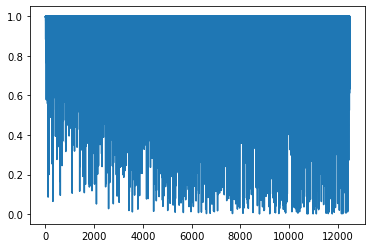

In [12]:
plt.plot(train_losses)

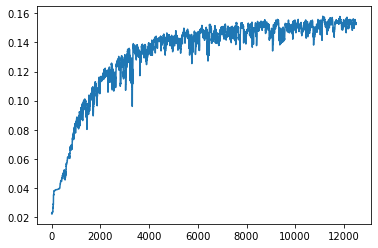

In [13]:
plt.plot(train_values)

In [6]:
train_losses2, train_values2 = train_loop(model, optimizer, train_dataloader, n_epochs=50, loss_func=banditnet_loss)

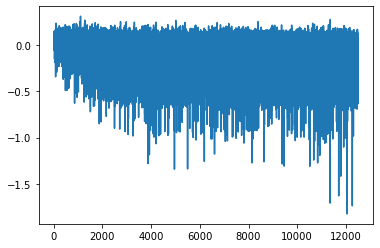

In [7]:
plt.plot(train_losses2)

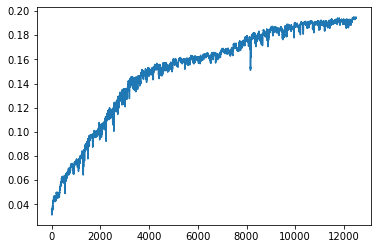

In [8]:
plt.plot(train_values2)